In [0]:
# Import the relevant modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn as skl
import statsmodels.formula.api as smf
import statsmodels as sm

In [2]:
# Read in the baseball data
! if [ ! -e baseball.csv ] ; \
  then wget https://raw.githubusercontent.com/mwang103/Project1/master/baseball.csv; \
fi
  
df = pd.read_csv('baseball.csv')

--2019-10-07 17:46:56--  https://raw.githubusercontent.com/mwang103/Project1/master/baseball.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67157 (66K) [text/plain]
Saving to: ‘baseball.csv’

baseball.csv        100%[===================>]  65.58K  --.-KB/s    in 0.02s   

2019-10-07 17:46:56 (2.57 MB/s) - ‘baseball.csv’ saved [67157/67157]



In [3]:
# Create new columns to compute run differential (RD) and on base + slugging (OPS)
df = df.assign(RD = lambda x: x.RS - x.RA)
df = df.assign(OPS = lambda x: x.OBP + x.SLG)

# Uncomment this line to select only the data since 1994, when MLB changed to a 3 round playoff format
# Technically, in 2012 MLB expanded the wild card, but this dataset only goes up to 2012 so there'd only be one year of data available
# df = df[df['Year'] >= 1994]

df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD,OPS
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415,46,0.746
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378,100,0.709
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403,7,0.728
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428,-72,0.730
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424,-146,0.680


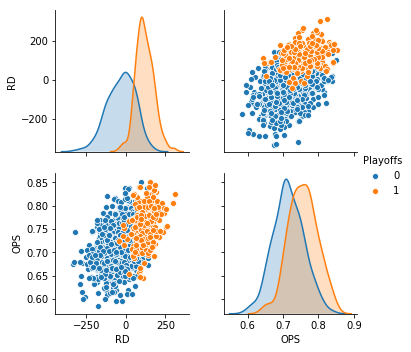

In [4]:
# Plot the variables we're interested in, classified by whether or not teams made the playoffs
sns.pairplot(df, vars = ['RD', 'OPS'], hue = 'Playoffs')


**It looks like teams that make the playoffs have higher RD and higher OPS**

In [5]:
# Separate into training and testing data
# Run the logistic regression and print the results
trainFraction = .75
np.random.seed(10)
sample = np.random.uniform(size = df.shape[0]) < trainFraction

x = df[['RD', 'OPS']]
y = df[['Playoffs']]
x = sm.tools.add_constant(x)

xtraining = x[sample]
xtesting = x[~sample]
ytraining = y[sample]
ytesting = y[~sample]

fit = sm.discrete.discrete_model.Logit(ytraining, xtraining).fit()
ytraining = ytraining.values
ytesting = ytesting.values
fit.summary()

Optimization terminated successfully.
         Current function value: 0.250699
         Iterations 8


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Playoffs   No. Observations:                  916
Model:                          Logit   Df Residuals:                      913
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Oct 2019   Pseudo R-squ.:                  0.4941
Time:                        17:46:57   Log-Likelihood:                -229.64
converged:                       True   LL-Null:                       -453.90
Covariance Type:            nonrobust   LLR p-value:                 4.040e-98
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2306      2.150     -3.829      0.000     -12.444      -4.017
RD             0.0307      0.003     11.873      0.000       0.026       0.036
OPS            6.8895      2.927      2.354      0.019       1.152      12.627
==============================================================================
"""

In [0]:
# Check the model on the training data
# Loop through probability thresholds and compute accuracy, sensitivity, and specificity of our model at each threshold
p_thresholds = np.linspace(0,1,101)

acc = np.zeros(101)
sens = np.zeros(101)
spec = np.zeros(101)

counter = 0
for p in p_thresholds:

  yhat_train = fit.predict(xtraining)
  yhat_train = pd.Series(yhat_train).values
  yhat_train = np.reshape(yhat_train, (len(yhat_train),-1))
  
  yhat_train[yhat_train > p ] = 1
  yhat_train[yhat_train != 1] = 0

  acc[counter] = np.mean(ytraining == yhat_train)
  sens[counter] = np.mean(yhat_train[ytraining == 1] == ytraining[ytraining == 1])
  spec[counter] = np.mean(yhat_train[ytraining == 0] == ytraining[ytraining == 0])
  
  counter = counter + 1

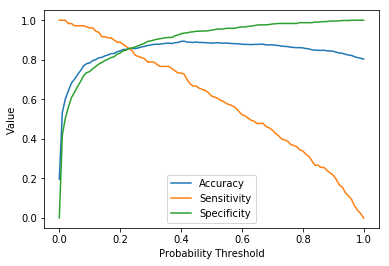

In [7]:
# Plot the accuracy, sensitivity, and specificity vs. the probability threshold for the training data
plt.plot(p_thresholds,acc, label = 'Accuracy')
plt.plot(p_thresholds,sens, label = 'Sensitivity')
plt.plot(p_thresholds,spec, label = 'Specificity')
plt.legend()
plt.xlabel('Probability Threshold')
plt.ylabel('Value')
plt.show()

In [0]:
# Run the model on the testing data
# Loop through probability thresholds and compute accuracy, sensitivity, and specificity of our model at each threshold
p_thresholds = np.linspace(0,1,101)

acc = np.zeros(101)
sens = np.zeros(101)
spec = np.zeros(101)

counter = 0
for p in p_thresholds:

  yhat_testing = fit.predict(xtesting)
  yhat_testing = pd.Series(yhat_testing).values
  yhat_testing = np.reshape(yhat_testing, (len(yhat_testing),-1))
  
  yhat_testing[yhat_testing > p ] = 1
  yhat_testing[yhat_testing != 1] = 0

  acc[counter] = np.mean(ytesting == yhat_testing)
  sens[counter] = np.mean(yhat_testing[ytesting == 1] == ytesting[ytesting == 1])
  spec[counter] = np.mean(yhat_testing[ytesting == 0] == ytesting[ytesting == 0])
  
  counter = counter + 1

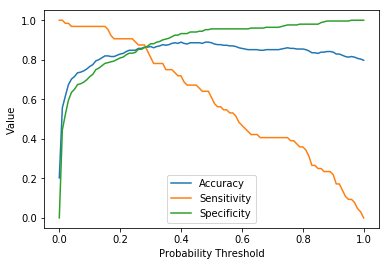

In [9]:
# Plot the accuracy, sensitivity, and specificity vs. the probability threshold for the testing data
plt.plot(p_thresholds,acc, label = 'Accuracy')
plt.plot(p_thresholds,sens, label = 'Sensitivity')
plt.plot(p_thresholds,spec, label = 'Specificity')
plt.legend()
plt.xlabel('Probability Threshold')
plt.ylabel('Value')
plt.show()

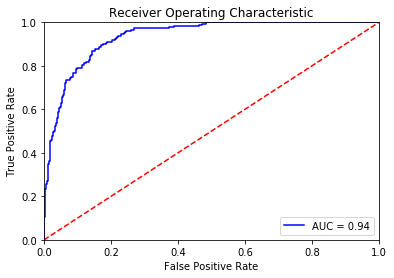

In [10]:
# Plot an ROC curve for the training data
# Code from bcaffo notebook 5

phatTesting = fit.predict(xtraining)
fpr, tpr, threshold = skl.metrics.roc_curve(ytraining, phatTesting)
roc_auc = skl.metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

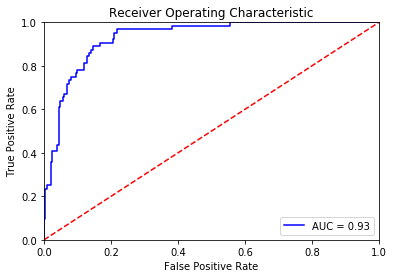

In [11]:
# Plot an ROC curve for the testing data
# Code from bcaffo notebook 5

phatTesting = fit.predict(xtesting)
fpr, tpr, threshold = skl.metrics.roc_curve(ytesting, phatTesting)
roc_auc = skl.metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
# Find the optimal probability threshold for our model by minimizing the distance to (0,1) on the ROC curve
dist = np.zeros(len(threshold))
for i in range(len(fpr)):
  curr = np.array([fpr[i], tpr[i]])
  dist[i] = np.linalg.norm(curr - np.array([0,1]))
min_dist = np.where(dist == min(dist))
opt_p = threshold[min_dist][0]

print(opt_p)

0.25986178962460244


In [13]:
# Now, let's see how our model fares for this year's MLB playoff data
# Read in 2019 data, which I compiled from baseball-reference.com and espn.com
! if [ ! -e MLB2019.csv ] ; \
  then wget https://raw.githubusercontent.com/mwang103/Project1/master/MLB2019.csv; \
fi
  
df2 = pd.read_csv('MLB2019.csv')

--2019-10-07 17:46:59--  https://raw.githubusercontent.com/mwang103/Project1/master/MLB2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1207 (1.2K) [text/plain]
Saving to: ‘MLB2019.csv’

MLB2019.csv         100%[===================>]   1.18K  --.-KB/s    in 0s      

2019-10-07 17:46:59 (136 MB/s) - ‘MLB2019.csv’ saved [1207/1207]



In [14]:
# Again, calculate RD and OPS
df2 = df2.assign(RD = lambda x: x.RS - x.RA)
df2 = df2.assign(OPS = lambda x: x.OBP + x.SLG)
df2.head()

,Team,League,W,RS,RA,OBP,SLG,BA,Playoffs,RD,OPS
0,ARI,NL,85,813,743,0.323,0.434,0.252,0,70,0.757
1,ATL,NL,97,855,743,0.336,0.452,0.258,1,112,0.788
2,BAL,AL,54,729,981,0.310,0.415,0.246,0,-252,0.725
3,BOS,AL,84,901,828,0.340,0.466,0.269,0,73,0.806
4,CHC,NL,84,814,717,0.331,0.452,0.252,0,97,0.783


In [15]:
# Run our model against this data and evaluate our accuracy, sensitivity, and specificity
x_2019 = df2[['RD', 'OPS']]
y_2019 = df2[['Playoffs']].values
x_2019 = sm.tools.add_constant(x_2019)


yhat_2019 = fit.predict(x_2019)
yhat_2019 = pd.Series(yhat_2019).values
yhat_2019 = np.reshape(yhat_2019, (len(yhat_2019),-1))

yhat_2019[yhat_2019 > opt_p] = 1
yhat_2019[yhat_2019 != 1] = 0

acc = np.mean(y_2019 == yhat_2019)
sens = np.mean(y_2019[y_2019 == 1] == yhat_2019[y_2019 == 1])
spec = np.mean(y_2019[y_2019 == 0] == yhat_2019[y_2019 == 0])

print('Calculated accuracy is:')
print(acc)
print('')

print('Calculated sensitivity is:')
print(sens)
print('')

print('Calculated specificity is:')
print(spec)

Calculated accuracy is:
0.8333333333333334

Calculated sensitivity is:
0.9

Calculated specificity is:
0.8


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
